In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from timeit import default_timer as timer
from collections import namedtuple

Transition = namedtuple('transition', ('state', 'action', 'reward', 'next_state'))

In [12]:
# Logging

mean_returns, std_devs = [], []

def plot_durations(durations):
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

In [16]:
#========================================================================================#
# Multi-layer perceptron, each layer but the final being rectified
# <dims> is a list of input dimensions
#========================================================================================#
class Actor(nn.Module):
    def __init__(self, dims, discrete, device):
        super(Actor, self).__init__()
        self.discrete = discrete
        self.device = device
        self.n_layers = len(dims) - 1
        self.pi = torch.FloatTensor([math.pi]).to(device)
        
        if not discrete:
            action_dim = dims[-1]
            self.log_std = nn.Parameter(torch.zeros(1, action_dim))

        self.linears = nn.ModuleList(
            [nn.Linear(dims[i], dims[i+1]) for i in range(self.n_layers)])
        
        self.to(device)
    
    def forward(self, x):
        if self.n_layers == 1:
            return self.linears[0](x)

        for i in range(self.n_layers - 1):
            x = F.relu(self.linears[i](x))
            #x = torch.tanh(self.linears[i](x))
        
        if self.discrete:
            x = F.log_softmax(self.linears[-1](x), dim=-1)
            return x
        else:
            x = self.linears[-1](x)
            #x = torch.tanh(self.linears[-1](x))
            sigma_sq = torch.exp(self.log_std)
            return x, sigma_sq
    
    def sample_action(self, ob):
        observation = torch.from_numpy(ob).float().to(self.device)

        with torch.no_grad():
            if self.discrete:
                logits = self.forward(observation)
                dist = torch.distributions.Categorical(logits=logits)
                action = dist.sample()
                return action.item()
            else:
                mu, sigma_sq = self.forward(observation)
                z = torch.randn(mu.size(), device=device)
                action = mu + sigma_sq.sqrt() * z
                return action[0]
    
    # Return the log-probability of an outcome x given mu and sigma_sq
    def log_normal(self, x, mu, sigma_sq):
        logprobs = -(x-mu).pow(2)/(2*sigma_sq) - 0.5*(2*self.pi*sigma_sq).log()
        return torch.sum(logprobs, 1)
        
    def train(self, optimizer, ob_no, ac_na, adv_n):
        optimizer.zero_grad()

        if self.discrete:
            logits = self.forward(ob_no)
            ac_na.unsqueeze_(1)
            logprob_n = logits.gather(1, ac_na).squeeze()
        else:
            mu_na, sigma_sq = self.forward(ob_no.float())
            logprob_n = self.log_normal(ac_na, mu_na, sigma_sq)

        weighted_neg_likelihoods = torch.mul(-logprob_n, adv_n)
        loss = torch.mean(weighted_neg_likelihoods)

        # Optimization step
        loss.backward()   
        optimizer.step()

        return
        
class Critic(nn.Module):
    def __init__(self, dims, num_grad_steps_per_target_update, num_target_updates, device):
        super(Critic, self).__init__()
        self.num_grad_steps_per_target_update = num_grad_steps_per_target_update
        self.num_target_updates = num_target_updates
        self.device = device
        self.n_layers = len(dims) - 1
        self.linears = nn.ModuleList(
            [nn.Linear(dims[i], dims[i+1]) for i in range(self.n_layers)])
        self.to(device)
    
    def forward(self, x):
        for i in range(self.n_layers - 1):
            x = F.relu(self.linears[i](x))
            #x = torch.tanh(self.linears[i](x))
         
        x = self.linears[-1](x)
        return x
    
    def train(self, optimizer, gamma, ob_no, r_n, next_ob_no, non_final_mask):
        
        lossfn = nn.MSELoss()
        
        for i in range(self.num_target_updates):
            v_n = self.forward(ob_no).squeeze()
            v_next_n = torch.zeros_like(v_n, device=self.device, requires_grad=False)
            with torch.no_grad():
                v_next_n[non_final_mask] = self.forward(next_ob_no).squeeze()
                  
            target = r_n + gamma * v_next_n
            
            optimizer.zero_grad()
            loss = lossfn(v_n, target)
            loss.backward(retain_graph=True)  
            
            for j in range(self.num_grad_steps_per_target_update):
                optimizer.step()

In [73]:
# Environment configuration
environments = [
    'CartPole-v0',
    'Pendulum-v0',
    'MountainCar-v0',
    'LunarLanderContinuous-v2',
    'BipedalWalker-v2',
    'BipedalWalkerHardcore-v2']

env_name=environments[1]
env = gym.make(env_name)
discrete = isinstance(env.action_space, gym.spaces.Discrete) 
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# Learning parameters
n_iter=500
max_path_length=env.spec.max_episode_steps
min_timesteps_per_batch=max_path_length*10
gamma=0.99
learning_rate=1e-3
normalize_advantages=True
num_target_updates=100
num_grad_steps_per_target_update=10

# Observation and action sizes
ob_dim = env.observation_space.shape[0]
ac_dim = env.action_space.n if discrete else env.action_space.shape[0]

# Network dimensions
pnet_dims = [ob_dim,
             128,
             128,
             ac_dim]
cnet_dims = [ob_dim,
             128,
             128,
             1]

actor = Actor(pnet_dims, discrete, device)
p_optimizer = optim.Adam(actor.parameters(), lr=learning_rate)

critic = Critic(cnet_dims, num_grad_steps_per_target_update, num_target_updates, device)
c_optimizer = optim.Adam(critic.parameters(), lr=learning_rate)

In [77]:
durations, returns = [], []
total_timesteps = 0
start = timer()

for itr in range(n_iter):
    #print("********** Iteration %i ************"%itr)  
    timesteps_this_batch = 0
    transitions = []
    
    # Collect paths until we have enough timesteps for a batch
    while True:
        rewards = []
        ob = env.reset().squeeze()
        steps = 0
        
        # Step through the environment
        while True:
            ac = actor.sample_action(ob)
            if not discrete:
                ac = ac.detach().cpu().numpy()
            ob_, rew, done, _ = env.step(ac)
            rewards.append(rew)
            ob_ = None if done else ob_.squeeze()
            transitions.append(Transition(ob, ac, rew, ob_))
            ob = ob_
            steps += 1
            if done or steps > max_path_length:
                break
        
        durations.append(steps)
        returns.append(sum(rewards))
        timesteps_this_batch += steps
        if timesteps_this_batch > min_timesteps_per_batch:
            break

    total_timesteps += timesteps_this_batch

    ob_no = torch.tensor([t.state for t in transitions], device=device, dtype=torch.float32)
    ac_na = torch.tensor([t.action for t in transitions], device=device)
    r_n = torch.tensor([t.reward for t in transitions], device=device)
    next_ob_no = torch.tensor([t.next_state for t in transitions if t.next_state is not None],
                              dtype=torch.float32, device=device)
    non_final_mask = torch.tensor([1 if t.next_state is not None else 0 for t in transitions],
                                  dtype=torch.uint8, device=device)

    # Update the critic
    critic.train(c_optimizer, gamma, ob_no, r_n, next_ob_no, non_final_mask)

    # Compute advantage for each transition
    with torch.no_grad():
        v_n = critic(ob_no).squeeze()
        v_next_n = torch.zeros_like(v_n, device=device)
        v_next_n[non_final_mask] = critic(next_ob_no).squeeze()

    adv_n = r_n + gamma * v_next_n - v_n
        
    # Advantage normalisation
    if normalize_advantages:
        adv_n = (adv_n - adv_n.mean()) / (adv_n.std() + 1e-10)
        
    # Update the actor
    actor.train(p_optimizer, ob_no, ac_na, adv_n)
    
end = timer()
print(end - start)

677.1454904999991


Average return: -914.22
Return std dev: 333.93


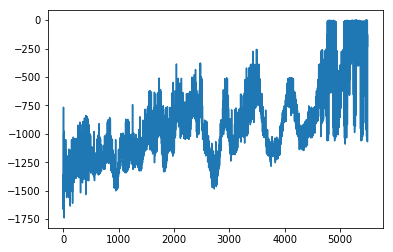

In [78]:
print("Average return: %.2f" % np.mean(returns))
print("Return std dev: %.2f" % np.std(returns))
#plot_durations(durations)
plt.plot(returns)

In [79]:
# Demonstration of policy
env = gym.make(env_name)
for ep in range(5):
    obs = env.reset()
    for t in range(env.spec.max_episode_steps):
        env.render()
        ac = actor.sample_action(obs)
        if not discrete:
            ac = ac.cpu().numpy()
        obs, r, done, _ = env.step(ac)
        if done:
            break
env.close()